HG02492 hap1 chr21
HG02666 hap2 chr15
HG03065 hap2 chrY
HG03520 hap2 chr21
HG03732 hap2 chrY
NA18939 hap1 chr2
NA19036 hap1 chr21
NA19036 hap2 chr14
NA19239 hap1 chr10
NA19347 hap2 chr21
NA19434 hap2 chr20
NA19650 hap1 chr2
NA19836 hap1 chr22
NA20355 hap1 chr19
NA20847 hap2 chr17
Summary per haploid assembly
verkko median N T2T contig per AU: 5.0
verkko median N T2T scaffold per AU: 4.0
verkko median N T2T any per AU: 10.0
verkko total N T2T contig per AU: 602
verkko total N T2T scaffold per AU: 559
verkko total N T2T any per AU: 1161
Summary per genome
verkko median N T2T contig wg: 10.0
verkko median N T2T scaffold wg: 8.0
verkko median N T2T any wg: 18.0
verkko total N T2T contig wg: 602
verkko total N T2T scaffold wg: 559
verkko total N T2T any wg: 1161


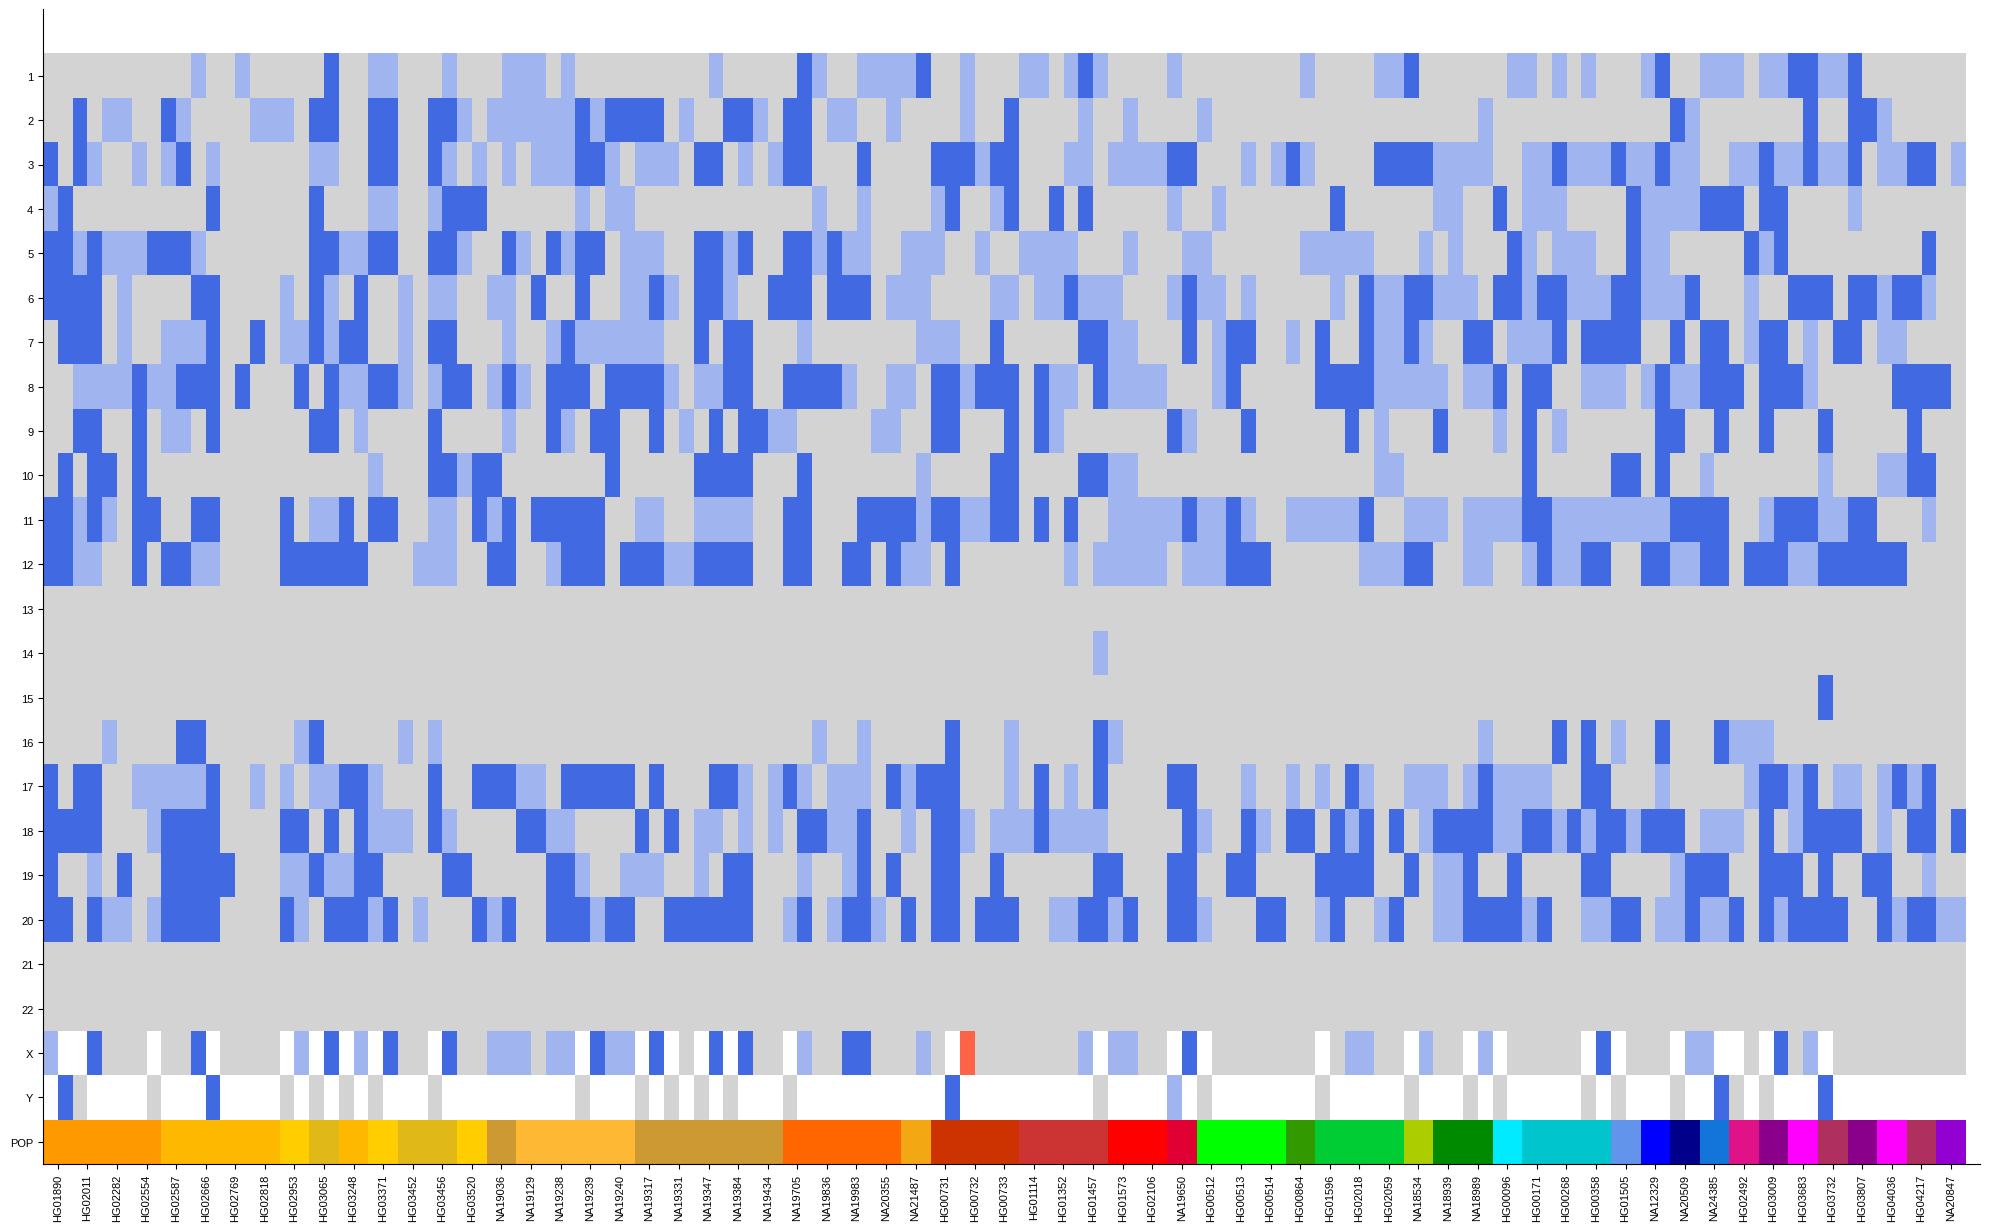

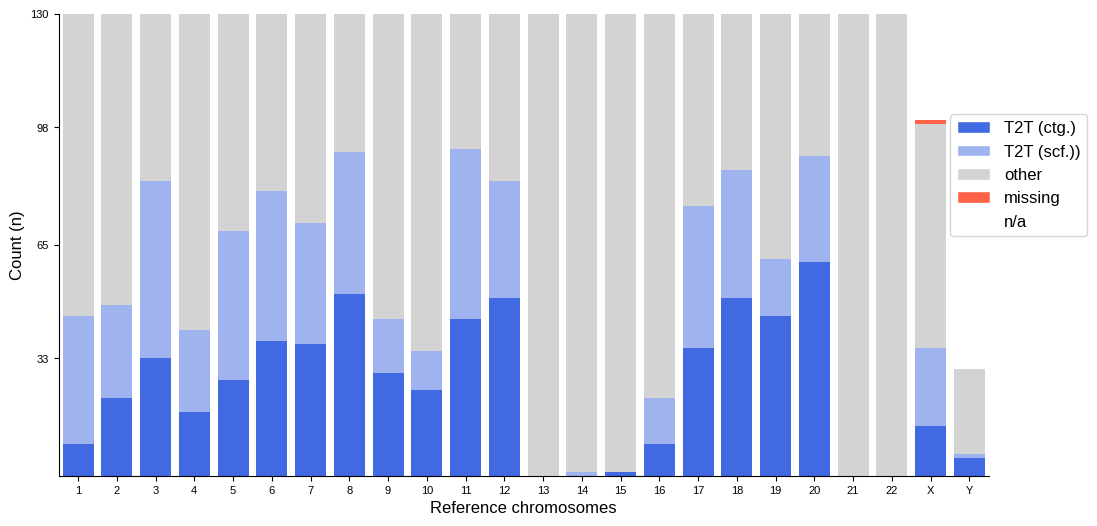

In [10]:
import pathlib
import pickle as pck

%cd -q "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/notebooks"
_PROJECT_CONFIG_NB = str(pathlib.Path("00_project_config.ipynb").resolve(strict=True))
_PLOT_CONFIG_NB = str(pathlib.Path("05_plot_config.ipynb").resolve(strict=True))
_ASSM_STATS_NB = str(pathlib.Path("10_assm_stats.ipynb").resolve(strict=True))
_CACHE_SEQ_NB = str(pathlib.Path("caching", "cache-seq-lengths.ipynb").resolve(strict=True))

%run $_PROJECT_CONFIG_NB
%run $_PLOT_CONFIG_NB
%run $_ASSM_STATS_NB
%run $_CACHE_SEQ_NB

_MYNAME="plot-t2t-chrom"
_MYSTAMP=get_nb_stamp(_MYNAME)

_MY_OUT_PATH = PLOT_OUT_MAIN_FIG1.joinpath("panels")

import collections as collect
import statistics as stat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb as name_to_rgb
import random as rand

rand.seed()

t2t_criteria = "strict"
assembler = "verkko"

asm_infix = None
if assembler == "verkko":
    asm_infix = "vrk-ps-sseq"
if assembler == "hifiasm":
    asm_infix = "hsm-ps-sseq"


# see NB:
# notebooks/plotting/main_fig1/plot-qv-estimates.ipynb
cache_qv_table = PROJECT_BASE.joinpath(
    "annotations", "autogen", f"{assembler}_qv-est.tsv"
)

# see NB:
# notebooks/caching/cache-seq-lengths.ipynb
cache_ngap_table = PROJECT_NB_CACHE.joinpath("cache.gapseq.pck")

karyo_est = PROJECT_DATA_ROOT.joinpath(
    "2023_karyo_est", "hgsvc3", f"{assembler}",
    f"karyo-est.hgsvc3-{assembler}.tsv"
)

annotation_source = PROJECT_DATA_ROOT.joinpath(
    "2024_ref_span", "hgsvc3", f"{assembler}"
)


cache_file_chrom_t2t_status = PROJECT_NB_CACHE.joinpath(f"chrom_t2t_status.{assembler}.pck")


T2T_LABEL_COLOR_MAP = collect.OrderedDict({
    "t2t": (*name_to_rgb("royalblue"), 1),
    "t2t_ctg": (*name_to_rgb("royalblue"), 1),
    "t2t_ngap": (*name_to_rgb("royalblue"), 0.5),
    "t2t_scf": (*name_to_rgb("royalblue"), 0.5),
    "near_t2t": (*name_to_rgb("darkviolet"), 1),
    "near_t2t_ngap": (*name_to_rgb("darkviolet"), 0.5),
    "other": (*name_to_rgb("lightgrey"), 1),
    "missing": (*name_to_rgb("tomato"), 1),
    "na": (*name_to_rgb("white"), 1),
})


def add_scalar_jitter(value):
    jitter = rand.gauss(0,0.05)
    return value + jitter    


def read_karyotype_table(file_path, assembler=assembler):
    
    df = pd.read_csv(file_path, sep="\t", header=0, comment="#")
    lut = dict()
    for row in df.itertuples():
        if "HG00733R" in row.sample:
            continue
        if asm_infix not in row.sample:
            raise ValueError(assembler)
        lut[row.sample.split(".")[0], row.asm_unit.split("-")[-1]] = row.karyotype
    return lut


def read_cached_qv_est(file_path):
    
    file_path.resolve(strict=True)
    df = pd.read_csv(file_path, sep="\t", header=0, comment="#")
    lut = dict(
        ((row.sample, row.sequence), (row.merqury_qv_est + row.variant_qv_est)//2) for row
        in df.itertuples()
    )
    return lut


def read_cached_ngap_summary(file_path):
    # 2024-12-10
    # obsolete version used for submission / HG00514-v1
    raise
    file_path.resolve(strict=True)  
    df = pd.read_csv(file_path, sep="\t", header=0)
    lut = dict(
        (sample, set(contigs)) for sample, contigs
        in df.groupby("sample")["contig"]
    )
    return lut


def read_ref_span_table(file_path, qv_est, ngaps, karyo):
    
    sample = file_path.name.split(".")[0]
    asm_unit = file_path.name.split(".")[2].split("-")[-1]

    df = pd.read_csv(file_path, sep="\t", header=0, comment="#")
    df["sample"] = sample
    df["asm_unit"] = asm_unit
    try:
        df["qv"] = [qv_est[(f"{row.sample}.{asm_infix}", row.contig)] for row in df.itertuples()]
    except KeyError:
        df["qv"] = [qv_est[(f"{row.sample}", row.contig)] for row in df.itertuples()]
    if sample in ngaps:
        ngap_lookup = sample
    else:
        ngap_lookup = f"{sample}.{asm_infix}"
    assert ngap_lookup in ngaps
    df["ngaps"] = df["contig"].apply(lambda c: 1 if c in ngaps[ngap_lookup] else 0)

    if (sample, "hap1") in karyo or (sample, "hap2") in karyo:
        karyo_lookup = sample
    else:
        karyo_lookup = f"{sample}.{asm_infix}"
    assert (karyo_lookup, "hap1") in karyo
    
    df["sex"] = [karyo.get((karyo_lookup, row.asm_unit), "any") for row in df.itertuples()]
    
    return df


def read_all_ref_span_tables(qv_est, ngaps, karyo):
    
    merged = []
    for table in annotation_source.glob("*.tsv"):
        df = read_ref_span_table(table, qv_est, ngaps, karyo)
        merged.append(df)
        
    merged = pd.concat(merged, axis=0, ignore_index=False)
    return merged


def labelize(criteria, single_contig, telo_p, telo_q, is_spanning, high_qual, no_gaps):
    
    assert criteria in ["strict", "lenient"]
    
    if criteria == "strict":
        has_telo = telo_p and telo_q
    else:
        has_telo = telo_p or telo_q
    
    check = [single_contig, has_telo, is_spanning, high_qual, no_gaps]
    if all(check):
        return "t2t_ctg"
        #return "t2t"
    check = [single_contig, has_telo, is_spanning, high_qual]
    if all(check):
        return "t2t_scf"
        #return "t2t_ngap"
    
    check = [has_telo, is_spanning, high_qual, no_gaps]
    if all(check):
        return "other"
        #return "near_t2t"
    check = [has_telo, is_spanning, high_qual]
    if all(check):
        return "other"
        #return "near_t2t_ngap"
    
    return "other"


def summarize_chromosome_status(ref_spans, criteria):
    
    assert criteria in ["strict", "lenient"]
    
    summary = dict()
    
    for (sample, hap, chrom), infos in ref_spans.groupby(["sample", "asm_unit", "chrom"]):
        if hap == "unassigned":
            continue
        assert infos["sex"].nunique() == 1
        is_single_contig = infos.shape[0] == 1
        if is_single_contig:
            contig_id = infos["contig"].iloc[0]
        else:
            contig_id = f"many.n={infos.shape[0]}"
        has_p_telomere = (infos["telo_p"] > 0).any()
        has_q_telomere = (infos["telo_q"] > 0).any()
        length_ratio = infos["length_ratio"].sum()
        if length_ratio > 1.1:
            print(sample, hap, chrom)
        if length_ratio < 0.2 and chrom in ["chr2", "chrY"]:
            print(sample, hap, chrom)
        is_spanning = length_ratio > 0.95
        if chrom == "chrY":
            is_spanning = length_ratio > 0.6
        if chrom == "chr9":
            is_spanning = length_ratio > 0.9
        high_quality = (infos["qv"] > 50).all()
        no_ngaps = (infos["ngaps"] < 1).all()
       
        label = labelize(
            criteria,
            is_single_contig, has_p_telomere, has_q_telomere,
            is_spanning, high_quality, no_ngaps
        )

        # this happens due to spurious alignments between X and Y / PAR
        au_sex = infos["sex"].iloc[0]
        if au_sex == "male" and chrom == "chrX":
            continue
        if au_sex == "female" and chrom == "chrY":
            continue

        summary[(sample, hap, chrom)] = (
            au_sex, contig_id, label,
            is_single_contig, has_p_telomere, has_q_telomere,
            is_spanning, high_quality, no_ngaps, length_ratio
        )
        summary[(sample, hap)] = infos["sex"].iloc[0]
    return summary


def cache_summary_info(assembler=assembler):

    if True:  # not cache_file_chrom_t2t_status.is_file():        
        qv = read_cached_qv_est(cache_qv_table)
        #ngaps = read_cached_ngap_summary(cache_ngap_table)
        ngaps = load_seqlen_cache("gapseq")
        karyo = read_karyotype_table(karyo_est)
        ref_spans = read_all_ref_span_tables(qv, ngaps, karyo)
        assm_summary = summarize_chromosome_status(ref_spans, t2t_criteria)
        with open(cache_file_chrom_t2t_status, "wb") as dump:
            pck.dump(assm_summary, dump)
    else:
        with open(cache_file_chrom_t2t_status, "rb") as dump:
            assm_summary = pck.load(dump)

    # NB: the following code block just exists
    # to produce the summary statistics;
    # the object above 'assm_summary' loaded from cache
    # is returned verbatim to the calling scope.
    
    # TODO move to other notebook
    per_assembly = collect.Counter()
    # ('HG00096', 'hap1', 'chr1') ('male', contig_id, 'other', False, True, True, True, True, True, 1.01)
    for key, value in assm_summary.items():
        if len(key) == 2:
            # this just maps to sex,
            # e.g. ('HG00096', 'hap1') --> male
            continue
        if key[2] in ["chrX", "chrY"]:
            sex = assm_summary[(key[0], key[1])]
            assert sex in ["male", "female"]
            if key[2] == "chrY" and sex == "male":
                per_assembly[(key[0], key[1], value[2])] += 1
            elif key[2] == "chrX" and sex == "female":
                per_assembly[(key[0], key[1], value[2])] += 1
            else:
                continue
        else:
            per_assembly[(key[0], key[1], value[2])] += 1

    per_au = collect.Counter()
    for (sample, au, label), value in per_assembly.items():
        if label == "t2t_ctg":
            per_au[(sample, au, "ctg")] += value
            per_au[(sample, au, "any")] += value
            per_au[(sample, None, "ctg")] += value
            per_au[(sample, None, "any")] += value
        if label == "t2t_scf":
            per_au[(sample, au, "scf")] += value
            per_au[(sample, au, "any")] += value
            per_au[(sample, None, "scf")] += value
            per_au[(sample, None, "any")] += value
    print("Summary per haploid assembly")
    t2t_ctg = [v for k,v in per_au.items() if k[-1] == "ctg" and k[1] is not None]
    t2t_scf = [v for k,v in per_au.items() if k[-1] == "scf" and k[1] is not None]
    t2t_any = [v for k,v in per_au.items() if k[-1] == "any" and k[1] is not None]
    median_ctg = np.median(t2t_ctg)
    median_scf = np.median(t2t_scf)
    median_any = np.median(t2t_any)
    print(f"{assembler} median N T2T contig per AU: {median_ctg}")
    print(f"{assembler} median N T2T scaffold per AU: {median_scf}")
    print(f"{assembler} median N T2T any per AU: {median_any}")
    print(f"{assembler} total N T2T contig per AU: {sum(t2t_ctg)}")
    print(f"{assembler} total N T2T scaffold per AU: {sum(t2t_scf)}")
    print(f"{assembler} total N T2T any per AU: {sum(t2t_any)}")

    print("Summary per genome")
    t2t_ctg = [v for k,v in per_au.items() if k[-1] == "ctg" and k[1] is None]
    t2t_scf = [v for k,v in per_au.items() if k[-1] == "scf" and k[1] is None]
    t2t_any = [v for k,v in per_au.items() if k[-1] == "any" and k[1] is None]
    median_ctg = np.median(t2t_ctg)
    median_scf = np.median(t2t_scf)
    median_any = np.median(t2t_any)
    print(f"{assembler} median N T2T contig wg: {median_ctg}")
    print(f"{assembler} median N T2T scaffold wg: {median_scf}")
    print(f"{assembler} median N T2T any wg: {median_any}")
    print(f"{assembler} total N T2T contig wg: {sum(t2t_ctg)}")
    print(f"{assembler} total N T2T scaffold wg: {sum(t2t_scf)}")
    print(f"{assembler} total N T2T any wg: {sum(t2t_any)}")
    return assm_summary


def plot_assembly_summary(assm_summary, label_color_map, full_output, ax):
    """
    This heatmap-like plot is a main figure 1 panel
    """
    long_labels = False
    ref_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    # switch order, start w/ chr1 at the top
    ref_chroms = ref_chroms[::-1]
    chrom_label = [c.strip("chr") for c in ref_chroms]
    hap_order = ["hap1", "hap2"]
    
    row_nums = HGSVC_TOTAL * len(hap_order)
    col_nums = len(ref_chroms) + 1
    
    row_label_pos = []
    row_labels = []
    
    im_matrix = np.ones(
        (row_nums, col_nums, 4)
    )
    red, green, blue, alpha = 0, 1, 2, 3
    
    chrom_summary = collect.defaultdict(collect.Counter)
    
    row = 0
    for pop, sample in get_samples_ordered_by_pop():
        pop_color = (*get_pop_color(sample), 1)
        row_label = sample
        
        current_sex = None
        for hap in hap_order:
            
            col = 1
            current_sex = assm_summary[(sample, hap)]
            for chrom in ref_chroms:
                try:
                    assm_spec = assm_summary[(sample, hap, chrom)]
                    current_sex = assm_spec[0]
                    # change 2024-08-20
                    # value at position [1] is now contig id
                    label = assm_spec[2]
                    assert label in label_color_map
                    r,g,b,a = label_color_map[label]
                except KeyError:
                    label = "missing"
                    r,g,b,a = label_color_map[label]
                    if current_sex is not None:
                        if current_sex == "female" and chrom == "chrY":
                            r,g,b,a = label_color_map["na"]
                            label = "na"
                        if current_sex == "male" and chrom == "chrX":
                            r,g,b,a = label_color_map["na"]
                            label = "na"
                            
                    # logic fix for HG00732
                    if (sample == "HG00732" and 
                        current_sex == "any" and 
                        chrom == "chrY" and 
                        label == "missing"):
                        r,g,b,a = label_color_map["na"]
                        label = "na"
                        
                chrom_summary[chrom][label] += 1
                            
                im_matrix[row, col, red] = r
                im_matrix[row, col, green] = g
                im_matrix[row, col, blue] = b
                im_matrix[row, col, alpha] = a
                
                im_matrix[row, 0, :] = pop_color
                
                col += 1
            if hap == "hap2":
                if current_sex == "male" and long_labels:
                    row_label += "|Y"
                elif long_labels:
                    row_label += "|X"
                else:
                    pass
                row_label_pos.append(row - 0.5 )
                row_labels.append(row_label)
            if hap == "hap1":
                if current_sex == "male" and long_labels:
                    row_label += " Y"
                elif long_labels:
                    row_label += " X"
                else:
                    pass
            row += 1

    im_matrix = np.swapaxes(im_matrix, 0, 1)        
        
    ax.imshow(
        im_matrix,
        aspect="auto"
    )
    
    ax.set_ylim(-0.5,col_nums+0.5)
    ax.set_xlim(-0.5,row_nums+0.5)

    y_ticks = [0] + list(range(1, 25))
    y_ticklabels = ["POP"] + chrom_label
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels)
    
    ax.set_xticks(row_label_pos)
    ax.set_xticklabels(row_labels, rotation=90)
    
    if full_output:
        output = ax, chrom_summary
    else:
        output = ax
    
    return output


def summarize_labels_by_chromosome(chrom_summary, label_color_map, ax):
    """
    This bar chart is a main figure 1 panel
    """
            
    ref_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    #ref_chroms = ref_chroms[::-1]
    bar_pos = list(range(1, 25))

    bottom = np.zeros(len(ref_chroms), dtype=float)    
    for label in label_color_map.keys():
        
        row_heights = np.array(
            [chrom_summary[c][label] for c in ref_chroms],
            dtype=float
        )
        label_color = label_color_map[label]
        ax.bar(
            bar_pos,
            row_heights,
            bottom=bottom,
            color=label_color
        )
        bottom += row_heights
        
    ax.set_xticks(bar_pos)
    ax.set_xticklabels([c.strip("chr") for c in ref_chroms])
    
    yticks = [33, 65, 98, 130]
    ax.set_yticks(yticks)
    ax.set_yticklabels(list(map(str, yticks)))
    
    ax.set_xlabel("Reference chromosomes")
    ax.set_ylabel("Count (n)")
    
    ax.set_xlim(0.5, 24.5)

    # realize via color map directly
    legend = build_patch_legend(
        [
            ("T2T (ctg.)", label_color_map["t2t_ctg"]),
            ("T2T (scf.))", label_color_map["t2t_scf"]),
            ("other", label_color_map["other"]),
            ("missing", label_color_map["missing"]),
            ("n/a", label_color_map["na"])
        ]
    )
    
    ax.legend(handles=legend, bbox_to_anchor=(0.95, 0.8))
        
    return ax


def make_t2t_scatter_plot(assm_summary, color_label_map):
    """
    This bar chart / scatter plot will go into the supplement
    and needs to be annotated for the large-scale errors in
    the assemblies (enumerate outliers and describe)
    """

    ref_chroms = [f"chr{i}" for i in range(1,23)] + ["chrX", "chrY"]
    ref_chroms = ref_chroms[::-1]
    y_ticks = list(range(1,25))

    x_points = []
    y_points = []
    colors = []
    
    for pop, sample in get_samples_ordered_by_pop():
        pop_color = (*get_pop_color(sample), 1)

        for hap in ["hap1", "hap2"]:

            for y_pos, chrom in zip(y_ticks, ref_chroms):

                try:
                    assm_spec = assm_summary[(sample, hap, chrom)]
                    assm_sex = assm_spec[0]
                    if assm_sex == "female" and chrom == "chrY":
                        continue
                    label = assm_spec[1]
                    length_ratio = assm_spec[-1]
                    color = color_label_map[label]
                    x_points.append(length_ratio)
                    y_points.append(add_scalar_jitter(y_pos))
                    colors.append(color)
                except KeyError:
                    assm_sex = assm_summary[(sample, hap)]
                    if assm_sex == "female" and chrom == "chrY":
                        continue
                    elif assm_sex == "male" and chrom == "chrX":
                        continue
                    elif assm_sex == "any" and chrom == "chrX":
                        # case for broken X / HG00732
                        color = label_color_map["missing"]
                        x_points.append(0.0)
                        y_points.append(y_pos)
                        colors.append(color)
                    elif assm_sex == "any" and chrom == "chrY":
                        assert sample == "HG00732"
                        continue
                    else:
                        raise

    fig, ax = plt.subplots(figsize=(4,8))

    ax.scatter(
        x_points,
        y_points,
        c=colors,
        alpha=0.75,
        s=10
        
    )

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(ref_chroms)

    ax.set_xlabel("T2T chromosome length covered (frac.)")

    return

#make_t2t_scatter_plot(assm_summary, label_color_map)


def create_t2t_matrix(skip_plot=False):

    assm_summary = cache_summary_info(assembler=assembler)

    fig, ax = plt.subplots(figsize=(25, 15))
    
    ax, chrom_summary = plot_assembly_summary(assm_summary, T2T_LABEL_COLOR_MAP, True, ax)
    if not skip_plot:
        for ext in DEFAULT_PLOT_EXT:
            out_path = _MY_OUT_PATH.joinpath(f"fig1_panel_t2t_matrix.{ext}")
            save_figure(out_path, fig)
        plt.close()

    pre_init_t2t_matrix = fnt.partial(plot_assembly_summary, *(assm_summary, T2T_LABEL_COLOR_MAP, False))

    return pre_init_t2t_matrix, chrom_summary


def create_t2t_barchart(chrom_summary, skip_plot):

    fig, ax = plt.subplots(figsize=(12,6))

    ax = summarize_labels_by_chromosome(chrom_summary, T2T_LABEL_COLOR_MAP, ax)
    if not skip_plot:
        for ext in DEFAULT_PLOT_EXT:
            out_path = _MY_OUT_PATH.joinpath(f"fig1_panel_t2t_barchart.{ASSEMBLER}.{ext}")
            save_figure(out_path, fig)
        plt.close()

    pre_init_t2t_barchart = fnt.partial(summarize_labels_by_chromosome, *(chrom_summary, T2T_LABEL_COLOR_MAP))
    return pre_init_t2t_barchart


get_t2t_matrix, chrom_summary = create_t2t_matrix(skip_plot=True)

get_t2t_barchart = create_t2t_barchart(chrom_summary, skip_plot=True)

#get_t2t_barscatter()